# Introduction

The goal of this project is to explore and analyze the data collected from the National Parks Service, to reveal if patterns exist for why some species are in conservation. The data in the observations dataset contains data observed over the last 7 days.


Questions that this project will answer:
- What are the most observed Bird & Amphibian and at what parks were they observed the most?
- What was the most observed species at each park?
- What species is more likely to be protected?
- Are the differences between species and their conservation status significant?

**Data sources:** 

`species_info.csv` and `observations.csv`, were provided by [codecademy.com](https://www.codecademy.com)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from scipy.stats import chi2_contingency

In [36]:
# Reading the data into seperte variables

species_df = pd.read_csv('species_info.csv')
observations_df = pd.read_csv('observations.csv')

In [37]:
# Displaying the first 10 rows of the datasets

display(species_df.head(10))
display(observations_df.head(10))

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN
5,Mammal,Odocoileus virginianus,White-Tailed Deer,NaN
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",NaN
7,Mammal,Canis latrans,Coyote,Species of Concern
8,Mammal,Canis lupus,Gray Wolf,Endangered
9,Mammal,Canis rufus,Red Wolf,Endangered


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85
5,Elymus virginicus var. virginicus,Yosemite National Park,112
6,Spizella pusilla,Yellowstone National Park,228
7,Elymus multisetus,Great Smoky Mountains National Park,39
8,Lysimachia quadrifolia,Yosemite National Park,168
9,Diphyscium cumberlandianum,Yellowstone National Park,250


This visual gives us a high level view of what to expect from the datasets.

In [38]:
# Lets verify the data types of the datasets

print('species dataset')
display(species_df.dtypes)


print('obervations dataset')
display(observations_df.dtypes)

species dataset


category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object

obervations dataset


scientific_name    object
park_name          object
observations        int64
dtype: object

This is what I was expecting. The only differce I can see to make here is to change `conservation_status` to a categorical datatype if I find it necessary for later analysis.

In [39]:
# Here we are finding if the dataset contains any duplicated rows.

species_duplicated = species_df.duplicated().sum()

observations_duplicated = observations_df.duplicated().sum()

print(f'The species dataset contains {species_duplicated} duplicated rows and the observations\
 dataset contains {observations_duplicated} duplicated rows.')

# Lets the drop the duplicated rows in the observations dataset
observations_df.drop_duplicates(inplace=True)
observations_duplicated = observations_df.duplicated().sum()
print(f'The observations dataset contains {observations_duplicated} duplicated rows.')


The species dataset contains 0 duplicated rows and the observations dataset contains 15 duplicated rows.
The observations dataset contains 0 duplicated rows.


In [40]:
# Here we are finding the unique conservation statuses for the species_df dataset

unique_conservation = [x for x in species_df.conservation_status.unique()]

print('This is a unique list of conservation statuses for the various species.')
print(unique_conservation)

print('I will assume that "nan" means that species is not in danger of extinction.')

This is a unique list of conservation statuses for the various species.
[nan, 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
I will assume that "nan" means that species is not in danger of extinction.


In [41]:
# I will change the 'nan' conservation status value to 'None'

species_df.conservation_status.fillna('None', inplace=True)

# Here I add a new column 'is_protected', to filter rows that are not equal to 'None' for 'conservation_status'

species_df['is_protected'] = species_df['conservation_status'] != 'None'

species_df.sample(10)

,category,scientific_name,common_names,conservation_status,is_protected
3783,Vascular Plant,Lonicera utahensis,Utah Honeysuckle,None,False
1442,Vascular Plant,Quercus muehlenbergii,"Chinkapin Oak, Yellow Oak",None,False
2896,Nonvascular Plant,Heterocladium macounii,Macoun's Heterocladium Moss,None,False
1830,Vascular Plant,Viola blanda var. blanda,Sweet White Violet,None,False
3481,Vascular Plant,Helianthus nuttallii,Nuttall's Sunflower,None,False
4153,Vascular Plant,Juncus ensifolius var. montanus,Rocky Mountain Rush,None,False
5079,Vascular Plant,Kalmia polifolia ssp. polifolia,Mountain Laurel,None,False
3670,Vascular Plant,Amaranthus blitoides,"Mat Amaranth, Prostrate Amaranth, Prostrate Pi...",None,False
4370,Vascular Plant,Physocarpus malvaceus,Mallow Ninebark,None,False
3816,Vascular Plant,Microsteris gracilis var. humilior,Slender Phlox,None,False


## Park analysis

In this section I aim to answer the question of how many species were observed in each park.

In [42]:
# I will first start by merging the two data sets to get an accuarte count of each category by park observed.

species_observations = species_df.merge(observations_df, how='inner', on='scientific_name')

display(species_observations)

,category,scientific_name,common_names,conservation_status,is_protected,park_name,observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,None,False,Bryce National Park,130
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,None,False,Yellowstone National Park,270
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,None,False,Great Smoky Mountains National Park,98
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,None,False,Yosemite National Park,117
4,Mammal,Bos bison,"American Bison, Bison",None,False,Yosemite National Park,128
...,...,...,...,...,...,...,...
25596,Vascular Plant,Vitis californica,"California Grape, California Wild Grape",None,False,Yellowstone National Park,237
25597,Vascular Plant,Tribulus terrestris,"Bullhead, Caltrop, Goathead, Mexican Sandbur, ...",None,False,Great Smoky Mountains National Park,50
25598,Vascular Plant,Tribulus terrestris,"Bullhead, Caltrop, Goathead, Mexican Sandbur, ...",None,False,Yellowstone National Park,239
25599,Vascular Plant,Tribulus terrestris,"Bullhead, Caltrop, Goathead, Mexican Sandbur, ...",None,False,Bryce National Park,111


In [43]:
# Here we will make a table containing the sum of obervations of species in each park

species_park_count = species_observations.groupby(['category', 'park_name'], as_index=False).observations.sum()

species_park_count['perc'] = species_park_count.observations.values /\
    species_park_count.groupby('category').observations.transform('sum')

species_park_count

,category,park_name,observations,perc
0,Amphibian,Bryce National Park,7542,0.167347
1,Amphibian,Great Smoky Mountains National Park,5876,0.130381
2,Amphibian,Yellowstone National Park,19937,0.442376
3,Amphibian,Yosemite National Park,11713,0.259896
4,Bird,Bryce National Park,58590,0.176686
5,Bird,Great Smoky Mountains National Park,42869,0.129277
6,Bird,Yellowstone National Park,143535,0.432848
7,Bird,Yosemite National Park,86612,0.261189
8,Fish,Bryce National Park,12823,0.175896
9,Fish,Great Smoky Mountains National Park,9482,0.130067


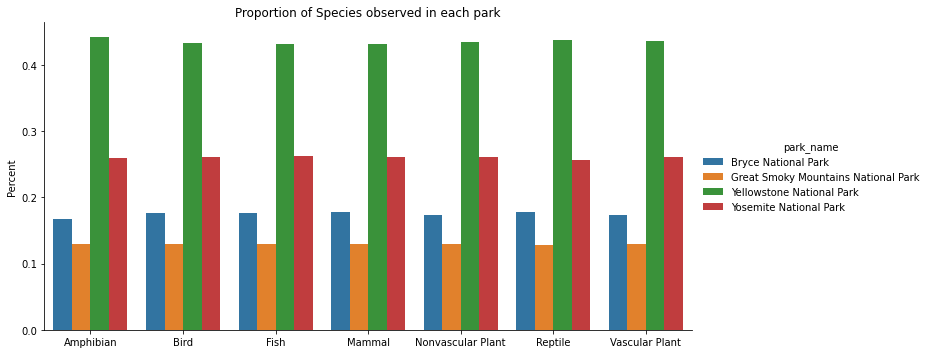

In [44]:
# Here we will create a visual of the observations of species in each park

sns.catplot(kind='bar', data=species_park_count, x='category', y='perc', hue='park_name', aspect=2)


plt.title('Proportion of Species observed in each park')
plt.xlabel('')
plt.ylabel('Percent')

plt.show()

In [45]:
# Here I made a pivot table to get a view of the protected vs. not protected species

species = species_df.groupby(['category', 'is_protected']).scientific_name.nunique()\
.reset_index().pivot(columns='is_protected', index='category', values='scientific_name').reset_index()

species.columns = ['category', 'not_protected', 'protected']

# Below, I add columns 'total, perc_protected'

species['total'] = species['not_protected'] + species['protected']

species['perc_protected'] = round(species['protected'] / species['total'] * 100 ,2)

species

,category,not_protected,protected,total,perc_protected
0,Amphibian,72,7,79,8.86
1,Bird,413,75,488,15.37
2,Fish,115,11,126,8.73
3,Mammal,146,30,176,17.05
4,Nonvascular Plant,328,5,333,1.50
5,Reptile,73,5,78,6.41
6,Vascular Plant,4216,46,4262,1.08


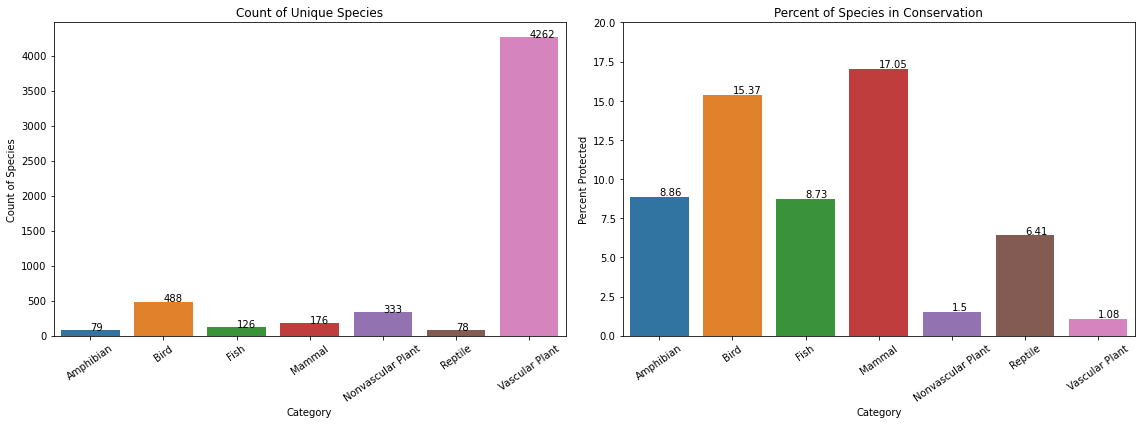

In [46]:
# I visualize the total count of species and percent of species in conservation

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)

sns.barplot(x=species.category, y=species.total)
for i in range(len(species)):
    plt.text(i, species.total[i] + .1, species.total[i])
    
plt.title('Count of Unique Species')
plt.ylabel('Count of Species')
plt.xlabel('Category')
plt.xticks(rotation=35)



plt.subplot(1, 2, 2)

sns.barplot(x=species.category, y=species.perc_protected)
for i in range(len(species)):
    plt.text(i, species.perc_protected[i] + .1, species.perc_protected[i])
    
plt.title('Percent of Species in Conservation')
plt.ylabel('Percent Protected')
plt.xlabel('Category')
plt.ylim(0.0, 20.0)
plt.xticks(rotation=35)


plt.tight_layout()
plt.show()

From this visual we can see Vascular Plants were the majority of speices observed. Another interesting detail we notice is that more than 15% of the Bird and Mammal category observed were in conservation (are protected). I would like to dive deeper into this and test for any levels of significance among birds and mammals in relation to their conservation status.

## Significance testing

Here I will conduct a significance test among the Bird and Mammal category against their conservation status for any level of significance.

In [47]:

birds_mammals = species_df[species_df['category'].isin(['Bird', 'Mammal'])]

birds_mammals_freq = pd.crosstab(birds_mammals.category, birds_mammals.conservation_status)

chi2, pval, dof, expected = chi2_contingency(birds_mammals_freq)

expected = pd.DataFrame(np.round(expected, 2), columns=birds_mammals_freq.columns, index=birds_mammals_freq.index)

display(expected)
display(birds_mammals_freq)

print(f'The test returned a p-value of {pval}.')

conservation_status,Endangered,In Recovery,None,Species of Concern,Threatened
category,,,,,
Bird,7.8,2.84,438.07,70.88,1.42
Mammal,3.2,1.16,179.93,29.12,0.58


conservation_status,Endangered,In Recovery,None,Species of Concern,Threatened
category,,,,,
Bird,4,3,442,72,0
Mammal,7,1,176,28,2


The test returned a p-value of 0.02208503627388743.


The p-value test statistic of 2.2% explains a significance between the Bird and Mammal category and their conservation status.

## Bird and Amphibian Frequency analysis


In this section, we find the most observed animal for the Amphibian and Bird category.

In [48]:
# Here I created a function to remove the punctuation marks from the names in the 'common_names' column

def just_words(text):
    for item in string.punctuation:
        text = text.replace(item, '')
    return text
  
# Here I created a list of lists, containing names without punctuation marks for better manipulation going forward

amph_words = species_df[species_df['category']=='Amphibian'].common_names.apply(just_words).str.split().tolist()
amph_words[:10]

[['Eastern', 'American', 'Toad'],
 ['Fowlers', 'Toad', 'Woodhouses', 'Toad'],
 ['Northern', 'Cricket', 'Frog'],
 ['Copes', 'Gray', 'Treefrog'],
 ['Gray', 'Treefrog'],
 ['Mountain', 'Chorus', 'Frog'],
 ['Northern', 'Spring', 'Peeper'],
 ['Upland', 'Chorus', 'Frog'],
 ['Striped', 'Chorus', 'Frog', 'Western', 'Chorus', 'Frog'],
 ['Eastern', 'NarrowMouthed', 'Toad']]

In [49]:
# Here I removed multiple instances of the same name from each individual list

amph_words2 = []
for item in amph_words:
    test = list({}.fromkeys(item))
    amph_words2.append(test)
    
amph_words2[:10]

[['Eastern', 'American', 'Toad'],
 ['Fowlers', 'Toad', 'Woodhouses'],
 ['Northern', 'Cricket', 'Frog'],
 ['Copes', 'Gray', 'Treefrog'],
 ['Gray', 'Treefrog'],
 ['Mountain', 'Chorus', 'Frog'],
 ['Northern', 'Spring', 'Peeper'],
 ['Upland', 'Chorus', 'Frog'],
 ['Striped', 'Chorus', 'Frog', 'Western'],
 ['Eastern', 'NarrowMouthed', 'Toad']]

In [50]:
# Here I unpacked each list to form 1 list

clean_amph_words = [x for l in amph_words2 for x in l]
clean_amph_words[:10]

['Eastern',
 'American',
 'Toad',
 'Fowlers',
 'Toad',
 'Woodhouses',
 'Northern',
 'Cricket',
 'Frog',
 'Copes']

In [51]:
# Here I created a series dataset of the previous list to get a 'value_counts' of each name mentioned

clean_amph = pd.Series(clean_amph_words).value_counts().head(10)

display(clean_amph)

print(f'Salamander is the most observed Amphibian in the dataset, being oberserved {clean_amph[0]} times.')

Salamander    41
Frog          14
Northern       8
Eastern        7
Toad           7
Southern       6
Chorus         5
Red            4
Mud            4
Spadefoot      3
dtype: int64

Salamander is the most observed Amphibian in the dataset, being oberserved 41 times.


In [52]:
# Here I added a new column to species_df named 'is_salamander' based off names in the 'common_names' column

species_df['is_salamander'] = species_df.common_names.str.contains(r'\bSalamander\b')

In [53]:
# Here I capture all mentions of True for 'is_salamander' and merged it with observations_df

# Then I displayed the first 10 rows of the new dataframe

salamander = species_df[species_df['is_salamander'] == True]

salamander = observations_df.merge(salamander)

salamander.head(10)

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_salamander
0,Eurycea longicauda longicauda,Yosemite National Park,147,Amphibian,Longtail Salamander,None,False,True
1,Eurycea longicauda longicauda,Bryce National Park,122,Amphibian,Longtail Salamander,None,False,True
2,Eurycea longicauda longicauda,Yellowstone National Park,258,Amphibian,Longtail Salamander,None,False,True
3,Eurycea longicauda longicauda,Great Smoky Mountains National Park,66,Amphibian,Longtail Salamander,None,False,True
4,Desmognathus wrighti,Yellowstone National Park,201,Amphibian,Pigmy Salamander,Species of Concern,True,True
5,Desmognathus wrighti,Bryce National Park,95,Amphibian,Pigmy Salamander,Species of Concern,True,True
6,Desmognathus wrighti,Great Smoky Mountains National Park,85,Amphibian,Pigmy Salamander,Species of Concern,True,True
7,Desmognathus wrighti,Yosemite National Park,127,Amphibian,Pigmy Salamander,Species of Concern,True,True
8,Plethodon aureolus,Bryce National Park,90,Amphibian,Tellico Salamander,None,False,True
9,Plethodon aureolus,Great Smoky Mountains National Park,69,Amphibian,Tellico Salamander,None,False,True


In [54]:
# Here I made a table to represent the total observations and percent of Salamanders in the parks

salamander_ob = salamander.groupby('park_name').observations.sum().sort_values().reset_index()

salamander_ob['percent'] = round(salamander_ob.observations / np.sum(salamander_ob.observations) ,2) * 100

salamander_ob

,park_name,observations,percent
0,Great Smoky Mountains National Park,3023,13.0
1,Bryce National Park,3946,17.0
2,Yosemite National Park,6174,26.0
3,Yellowstone National Park,10234,44.0


In [55]:
# Here I created a table displaying the observations of protected vs. not-protected Salamanders in each park along
# with the corresponding percentage

protected_salamander = salamander.groupby(['park_name', 'is_protected'], as_index=False)[['observations']].sum()

protected_salamander['percent'] = round(protected_salamander.observations / protected_salamander.groupby(['park_name'])['observations'].transform('sum'), 2) * 100

protected_salamander

,park_name,is_protected,observations,percent
0,Bryce National Park,False,3723,94.0
1,Bryce National Park,True,223,6.0
2,Great Smoky Mountains National Park,False,2863,95.0
3,Great Smoky Mountains National Park,True,160,5.0
4,Yellowstone National Park,False,9844,96.0
5,Yellowstone National Park,True,390,4.0
6,Yosemite National Park,False,5885,95.0
7,Yosemite National Park,True,289,5.0


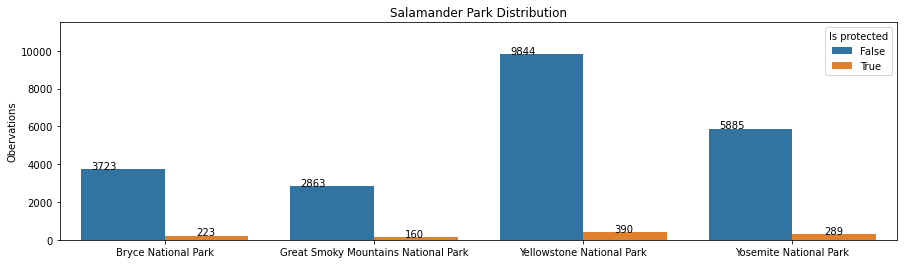

In [56]:
# Here I created a visual displaying the protected_salamander 'is_protected' column for each park

plt.figure(figsize=(15,4))

sns.barplot(data=protected_salamander, x = 'park_name', y = 'observations', hue ='is_protected')

plt.title('Salamander Park Distribution')
plt.xlabel('')
plt.ylabel('Obervations')
plt.legend(title='Is protected')

for i in range(len(protected_salamander)):
    plt.text(i/2 -.35, protected_salamander.observations[i], protected_salamander.observations[i])

plt.ylim(0, 11500)    
    
plt.show()

From this visual, we can see the majority of Salamanders were found in the Yellowstone National Park.

In [57]:
# Here I gather the common_names column for the Bird category as a list-of-lists and store it in a variable

bird = species_df[species_df['category'] == 'Bird'].common_names.apply(just_words).str.split().to_list()

bird[0:10]

[['Brewsters', 'Warbler'],
 ['Coopers', 'Hawk'],
 ['Northern', 'Goshawk'],
 ['SharpShinned', 'Hawk'],
 ['Golden', 'Eagle'],
 ['RedTailed', 'Hawk'],
 ['RedShouldered', 'Hawk'],
 ['BroadWinged', 'Hawk'],
 ['Northern', 'Harrier'],
 ['American', 'SwallowTailed', 'Kite', 'SwallowTailed', 'Kite']]

In [58]:
# Here I gather distinct names from the bird list created before

bird1 = []
for i in bird:
    text = list(dict.fromkeys(i))
    bird1.append(text)
    
bird1[0:10]

[['Brewsters', 'Warbler'],
 ['Coopers', 'Hawk'],
 ['Northern', 'Goshawk'],
 ['SharpShinned', 'Hawk'],
 ['Golden', 'Eagle'],
 ['RedTailed', 'Hawk'],
 ['RedShouldered', 'Hawk'],
 ['BroadWinged', 'Hawk'],
 ['Northern', 'Harrier'],
 ['American', 'SwallowTailed', 'Kite']]

In [59]:
# Here I unpack the lists containing the distinct bird common names and count the frequency of each name

bird2 = [x for l in bird1 for x in l]

pd.Series(bird2).value_counts()

Warbler        59
Sparrow        29
American       21
Northern       20
Owl            18
               ..
RedHeaded       1
RedCockaded     1
Downy           1
Hairy           1
Nuttalls        1
Length: 459, dtype: int64

As we can see, the Warbler is the most observed bird from the species dataset

In [60]:
# Here I create a new column, is_warbler, to capture all birds that are Warblers from the species dataframe

species_df['is_warbler'] = species_df[species_df['category']=='Bird'].common_names.str.contains(r'\bWarbler\b')

species_df.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_salamander,is_warbler
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,None,False,False,NaN
1,Mammal,Bos bison,"American Bison, Bison",None,False,False,NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",None,False,False,NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",None,False,False,NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,None,False,False,NaN


In [61]:
# Here I store all rows where is_warbler equals True in a variable, then merge it with the observations dataset

warb = species_df.loc[species_df['is_warbler']==True]

warb = warb.merge(observations_df)

warb.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_salamander,is_warbler,park_name,observations
0,Bird,Vermivora pinus X chrysoptera,Brewster's Warbler,None,False,False,True,Great Smoky Mountains National Park,98
1,Bird,Vermivora pinus X chrysoptera,Brewster's Warbler,None,False,False,True,Yosemite National Park,136
2,Bird,Vermivora pinus X chrysoptera,Brewster's Warbler,None,False,False,True,Yellowstone National Park,259
3,Bird,Vermivora pinus X chrysoptera,Brewster's Warbler,None,False,False,True,Bryce National Park,89
4,Bird,Dendroica caerulescens,Black-Throated Blue Warbler,None,False,False,True,Bryce National Park,94


In [62]:
# Here I created a dataset containing the sum of Warbler observatins grouped by park and their protected status

warb1 = warb.groupby(['park_name', 'is_protected'], as_index=False)[['observations']].sum()
warb1

,park_name,is_protected,observations
0,Bryce National Park,False,5565
1,Bryce National Park,True,195
2,Great Smoky Mountains National Park,False,4290
3,Great Smoky Mountains National Park,True,145
4,Yellowstone National Park,False,13995
5,Yellowstone National Park,True,492
6,Yosemite National Park,False,8441
7,Yosemite National Park,True,271


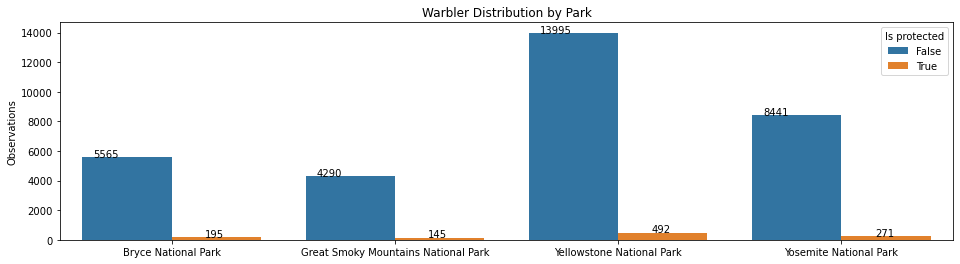

In [63]:
# Here is a barplot visualisation of the Warbler distribution by park and protected status

plt.figure(figsize=(16,4))

sns.barplot(data=warb1, x='park_name', y='observations', hue='is_protected')


plt.title('Warbler Distribution by Park')
plt.ylabel('Observations')
plt.xlabel('')
plt.legend(title='Is protected')


for i in range(len(warb1)):
    plt.text(i/2 -.35, warb1.observations[i], warb1.observations[i])

plt.show()

From this visual, we can see the majority of Warbler birds were found in the Yellowstone National Park. Is there a reason why the Yellowstone National Park has the majorty of the observances of a species?